In [11]:
import requests
import os
from datetime import datetime
from pathlib import Path
import pyarrow
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import contextily as cx
import seaborn as sns
from datetime import datetime
import matplotlib.colors as colors


root_dir = Path("~/Desktop/Desktop/epidemiology_PhD/00_repos/").expanduser()

url = "https://hub.arcgis.com/api/v3/datasets/025fb2ea05f14890b2b11573341b5b18_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"

output_dir = root_dir / "los_angeles_2025_fire_disasters/data/00_raw/calfire_boundaries"
data_dir = root_dir / "los_angeles_2025_fire_disasters/data"

so_cal_counties = ["025", "029", "037", "065", "059", "071", "073", "083", "111", "079"]

filename = f"data_2025_01_17.geojson"
output_path = os.path.join(output_dir, filename)

In [12]:
# prep data
# we need: a state of cali boundary,ct boundaries, fire boundaries, and the number of people exposed


# cali border
states = gpd.read_file(data_dir / "00_raw/cb_2018_us_state_500k.shp").to_crs(epsg=2229)
ca_boundary = states[states['NAME'] == 'California']

# census tracts
cts = gpd.read_file(data_dir / "00_raw/tl_2010_06_tract10.shp").to_crs(epsg=2229)
cts = cts[cts['COUNTYFP10'].isin(so_cal_counties)]
cts = cts[['geometry', 'GEOID10', 'COUNTYFP10']]
cts['GEOID10'] = cts['GEOID10'].astype(int)

# keep cts that are fully within ca boundary to avoid the outlines and coastlines
cts = gpd.clip(cts, ca_boundary)

# fire boundaries
fires = gpd.read_file(output_path).to_crs(epsg=2229)
fires["poly_DateCurrent"] = fires["poly_DateCurrent"].dt.tz_convert('US/Pacific')
fires = fires[fires['poly_DateCurrent'] > '2025-01-06']
fires["poly_DateCurrent"] = fires["poly_DateCurrent"].dt.date

# exposure data by ct 
exposure = pd.read_csv(data_dir / "02_processed/ct_exposures_2025_01_17.csv")
exposure_ct = exposure.rename(columns={'GEOID10': 'GEOID10', 'exposed_20buffer': 'exposed'})
exposure_ct = exposure_ct[['GEOID10', 'exposed']]

# merge
exposure_ct = cts.merge(exposure_ct, on='GEOID10', how='left')

# create LA exposure so that: places that are highly exposed and in LA are high exposed, places that are unexposed but in LA are low exposed, and places that are exposed but not in LA are medium exposed. labeled as least/less/high
exposure_ct.loc[exposure_ct['exposed'] == 1, 'exposed'] = 2
exposure_ct.loc[(exposure_ct['COUNTYFP10'] == '037') & (exposure_ct['exposed'] == 0), 'exposed'] = 1

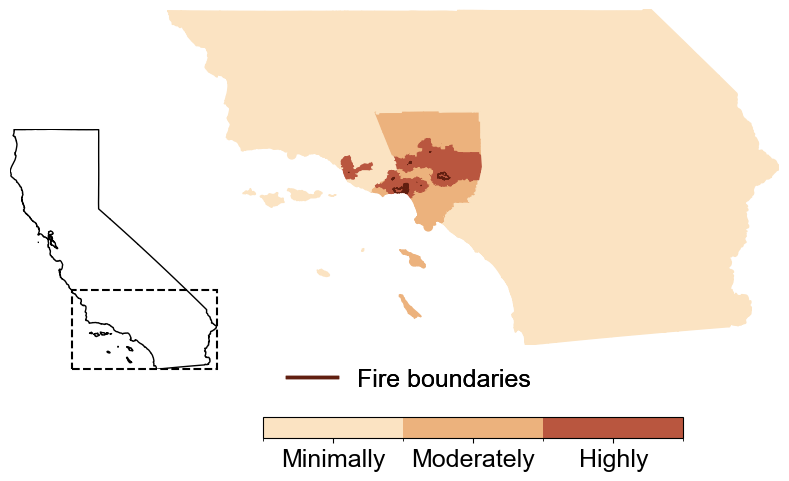

FileNotFoundError: [Errno 2] No such file or directory: '/Users/laurenwilner/Desktop/Desktop/epidemiology_PhD/00_repos/los_angeles_2025_fire_disasters_exp/03_output/figure_1_exposure.png'

In [ ]:
# make sure all data is in the same CRS (EPSG:3857 for web mercator)
fires = fires.to_crs(epsg=3857)
exposure_ct = exposure_ct.to_crs(epsg=3857)
ca_boundary = ca_boundary.to_crs(epsg=3857)

# some setup for the bounds for the inset map
bounds = exposure_ct.total_bounds
x_min, y_min, x_max, y_max = bounds

# make fonts BIG and ARIAL
plt.rcParams.update({'font.size': 20,
                    'font.family': 'sans-serif',
                    'font.sans-serif': ['Arial']}) 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20

# custom colormap 
# i couldnt load metbrewer in python so i just used the hex codes from the website
okeefe = ["#fbe3c2", "#f2c88f", "#ecb27d", "#e69c6b", "#d37750", "#b9563f", "#611F10"]
cmap = colors.ListedColormap([okeefe[0], okeefe[2], okeefe[5]])  # light, medium, dark orange
norm = colors.BoundaryNorm([-.5, 0.5, 1.5, 2.5], cmap.N) # this will center each color bin on 0,1,2

#### start plotting
fig = plt.figure(figsize=(12, 6)) 
# fig.suptitle('2025 LA wildfire exposure', fontsize=24, y=1.02)

#### left side: ca boundary
ax_left = fig.add_axes([0.1, 0.35, 0.4, 0.4])  # [left, bottom, width, height]

ca_boundary.boundary.plot(
    ax=ax_left,
    edgecolor='black',
    linewidth=1,
    facecolor='none'
)

# add rectangle to show study area
from matplotlib.transforms import Bbox
rect_bbox = Bbox([[x_min, y_min], [x_max, y_max]])
rect = plt.Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False,
    color="black",
    linewidth=1.5, 
    linestyle='--',
    clip_on=False, 
    transform=ax_left.transData 
)
ax_left.add_patch(rect)

# Force equal scaling to prevent distortion
ax_left.set_aspect('equal', adjustable='box')
ax_left.axis('off')

# bounds for the left plot
ca_bounds = ca_boundary.total_bounds
ax_left.set_xlim(ca_bounds[0], ca_bounds[2])
ax_left.set_ylim(ca_bounds[1], ca_bounds[3])

#### right plot - exposure data with cts
ax_right = fig.add_axes([0.25, 0.15, 0.7, 0.8])  # adjusted width to maintain aspect ratio

# calculate and set aspect ratio to prevent distortion for the two panels
aspect_ratio = (x_max - x_min) / (y_max - y_min)
ax_right.set_aspect(aspect_ratio)

# Plot census tracts with discrete colors
exposure_ct.plot(
    column='exposed',
    ax=ax_right,
    edgecolor='face',
    alpha=1,
    cmap=cmap,
    norm=norm,
    legend=False # need to make a custom legend! 
)

# Create colorbar separately
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(
    sm, 
    ax=ax_right,
    orientation='horizontal',
    ticks=[0, 1, 2],
    boundaries=[-0.1, 0.1, 0.9, 1.1, 1.9, 2.1],
    shrink=0.5
)
# cbar.set_label('Exposure status') -- dont need because joan says its obvious
cbar.ax.set_xticklabels(['Minimally', 'Moderately', 'Highly'], fontsize=18)

# add fire boundaries on top
fires.boundary.plot(
    ax=ax_right,
    color=okeefe[6],
    linewidth=.5,
    label='Fire boundaries'
)

# Create a second legend for fire boundaries
from matplotlib.lines import Line2D
fire_legend = ax_right.legend(
    handles=[Line2D([0], [0], color=okeefe[6], linewidth=2.5, label='Fire boundaries')],
    loc='upper right',
    bbox_to_anchor=(0.63, 0),  # adjust position as needed
    fontsize=18,
    frameon=False
)

# add in both legends
ax_right.add_artist(fire_legend)

# bounds for right side
ax_right.set_xlim(x_min, x_max)
ax_right.set_ylim(y_min, y_max)
ax_right.axis('off')


# get rid of figure outline
fig.patch.set_visible(False)
plt.show()

# save
fig.savefig(
    root_dir / "los_angeles_2025_fire_disasters/03_output/figure_1_exposure.png",
    dpi=300,
    bbox_inches='tight',
    pad_inches=0
)

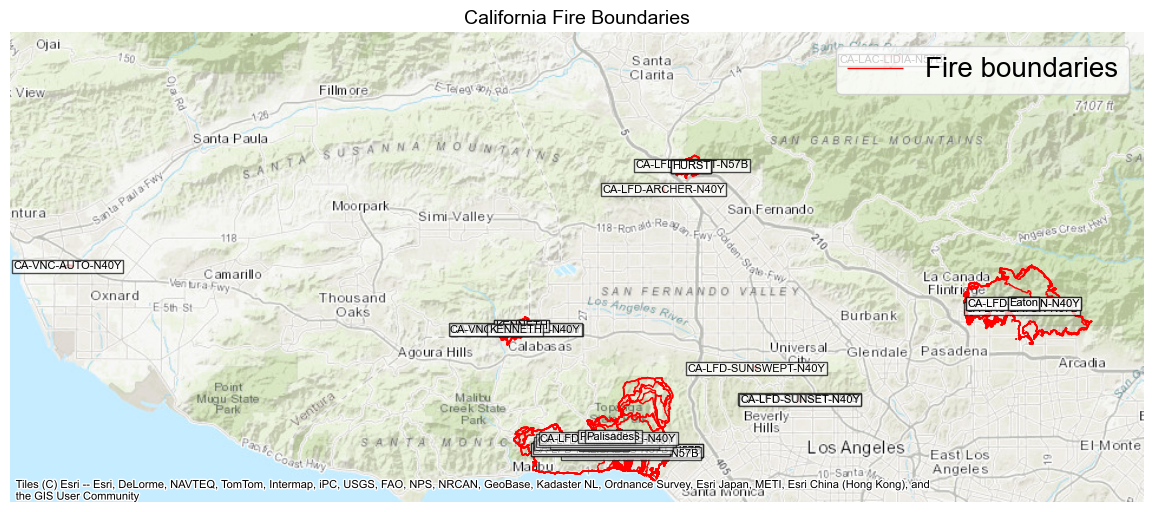

In [25]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Make sure your data is in Web Mercator projection for compatibility with contextily
fires_webmerc = fires.to_crs(epsg=3857)  # Convert to Web Mercator

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot fire boundaries
fires_webmerc.boundary.plot(
    ax=ax,
    linewidth=1,
    edgecolor='red',
    label='Fire boundaries'
)

# Add labels for each fire
for idx, row in fires_webmerc.iterrows():
    # Get centroid of polygon for label placement
    centroid = row.geometry.centroid
    # Use mission as the label
    label = row['mission']
    ax.annotate(label, (centroid.x, centroid.y), fontsize=8, 
                ha='center', va='center', color='black',
                bbox=dict(facecolor='white', alpha=0.7, pad=1))

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)  # You can choose different providers

# Add title and legend
ax.set_title('California Fire Boundaries', fontsize=14)
ax.legend(loc='upper right')

# Remove axis ticks and labels since the basemap provides context
ax.set_axis_off()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [16]:
fires

,OBJECTID,GlobalID,type,source,poly_DateCurrent,mission,incident_name,incident_number,area_acres,description,FireDiscoveryDate,CreationDate,EditDate,displayStatus,geometry
1175,1262,7ee0ab36-f6af-4ca9-96ed-170ebc0b0ba0,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,771.572356,FIRIS Perimeter,NaT,2025-01-07 22:09:29+00:00,NaT,Active,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
1176,1263,f4b2a2f8-b549-425a-8420-e11c78a5a9da,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,NaT,2025-01-07 23:13:25+00:00,NaT,Active,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
1177,1264,0bc1ddb3-63bf-4fd8-a01b-d522f57e4083,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,NaT,2025-01-07 23:13:25+00:00,NaT,Active,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
1178,1265,80a365ca-2de5-434e-8bd8-195405caefec,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,2920.451532,FIRIS Perimeter,NaT,2025-01-08 02:15:44+00:00,NaT,Active,"MULTIPOLYGON (((-13197072.563 4037345.979, -13..."
1179,1266,34c2af2a-54f0-4830-a99e-bd47edb2b503,Heat Perimeter,FIRIS,2025-01-08,CA-LFD-PALISADES-N57B,None,None,15832.376531,FIRIS Perimeter,NaT,2025-01-08 21:05:56+00:00,NaT,Active,"MULTIPOLYGON (((-13196404.887 4036980.194, -13..."
1180,1267,98243b68-f4d5-4467-b19f-cf88106e18e7,Heat Perimeter,FIRIS,2025-01-08,CA-LFD-PALISADES-N57B,None,None,15832.376531,FIRIS Perimeter,NaT,2025-01-08 21:05:56+00:00,NaT,Active,"MULTIPOLYGON (((-13196404.887 4036980.194, -13..."
1181,1268,0d7d92b4-e5b5-464e-a02b-e70dbd80d06d,Heat Perimeter,FIRIS,2025-01-08,CA-LAC-LIDIA-N57B,None,None,347.704224,FIRIS Perimeter,NaT,2025-01-09 01:26:26+00:00,NaT,Active,"POLYGON ((-13164156.207 4087252.805, -13164139..."
1182,1269,92579339-7dd4-4dd8-95c5-910ef0bb2c07,Heat Perimeter,FIRIS,2025-01-08,CA-LFD-SUNSET-N57B,None,None,19.840078,FIRIS Perimeter,NaT,2025-01-09 02:00:39+00:00,NaT,Active,"MULTIPOLYGON (((-13175107.093 4043154.47, -131..."
1183,1270,38e2219f-62eb-45f1-9016-8c3046633b97,Heat Perimeter,FIRIS,2025-01-08,CA-LAC-EATON-N57B,None,None,10589.956010,FIRIS Perimeter,NaT,2025-01-09 02:27:13+00:00,NaT,Active,"MULTIPOLYGON (((-13143136.241 4056925.853, -13..."
1184,1271,77755bff-6eb1-4e42-9809-1ad373ce6bdc,Heat Perimeter,FIRIS,2025-01-08,CA-LFD-HURST-N57B,None,None,663.395358,FIRIS Perimeter,NaT,2025-01-09 03:34:24+00:00,NaT,Active,"MULTIPOLYGON (((-13189450.36 4072675.797, -131..."
